## Data ingestion
1. Load Data
2. Select classes to predict

## Exploratory Data Analysis
1. Convert target label to multinomial class
2. Data Summary: Statistical description
3. Univariate and Bi-Variate Exploration

## Feature Engineering
1. Data Cleaning - Drop minuscule features 
2. Log Transformation for skewed data points/ Outliers detection and handling
3. Vectorize features
4. Standardize features
5. Train-test split
6. Handle Class imbalance
7. Visualize histogram for data spread, class distribution
6. Feature Selection - Correlation and chi-squared

## Model Building
## Model Evaluation

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.ml.stat import Correlation
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
from pyspark.ml.feature import VectorAssembler,StandardScaler, ChiSqSelector
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

In [32]:
sc.stop()

In [2]:
# Initializing a Spark session
conf = pyspark.SparkConf().setAppName('appName').setMaster('local')
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession(sc)

### 1.1 Data Ingestion

In [5]:
raw_data = spark.read.format("csv").option("header","true").option("inferSchema", "true").load(r"sulbha.ss.csv")
raw_data.columns

['AnonPuid',
 'Product_new_group_update',
 'tot_cnt',
 'PI_Others',
 'PI_Productivity_App',
 'PI_Entertainment_App',
 'PI_Casual_game',
 'PI_Core_game',
 'PI_Others_OperatingSystem',
 'PI_Others_Pass',
 'PI_MMTV',
 'PI_Other_App',
 'PI_Others_Device',
 'PI_Others_Bundle',
 'PI_Others_Music',
 'tot_Usage_Engagement',
 'Usage_Others',
 'Usage_Productivity_App',
 'Usage_Entertainment_App',
 'Usage_Casual_game',
 'Usage_Core_game',
 'Usage_Others_OperatingSystem',
 'Usage_Others_Pass',
 'Usage_MMTV',
 'Usage_Other_App',
 'Usage_Others_Device',
 'Usage_Others_Bundle',
 'Usage_Others_Music']

- Product_new_group_update = Target Group
- tot_cnt =  # of visits
- PI_... = Page impression, share of among all product cateory visit
- total_usage_engagement = time spent of site
- Usage_ ... = time spent on that product

In [6]:
raw_data.printSchema()

root
 |-- AnonPuid: integer (nullable = true)
 |-- Product_new_group_update: string (nullable = true)
 |-- tot_cnt: integer (nullable = true)
 |-- PI_Others: double (nullable = true)
 |-- PI_Productivity_App: double (nullable = true)
 |-- PI_Entertainment_App: double (nullable = true)
 |-- PI_Casual_game: double (nullable = true)
 |-- PI_Core_game: double (nullable = true)
 |-- PI_Others_OperatingSystem: double (nullable = true)
 |-- PI_Others_Pass: double (nullable = true)
 |-- PI_MMTV: double (nullable = true)
 |-- PI_Other_App: double (nullable = true)
 |-- PI_Others_Device: double (nullable = true)
 |-- PI_Others_Bundle: double (nullable = true)
 |-- PI_Others_Music: integer (nullable = true)
 |-- tot_Usage_Engagement: integer (nullable = true)
 |-- Usage_Others: integer (nullable = true)
 |-- Usage_Productivity_App: integer (nullable = true)
 |-- Usage_Entertainment_App: integer (nullable = true)
 |-- Usage_Casual_game: integer (nullable = true)
 |-- Usage_Core_game: integer (null

In [7]:
# quick sneak peak into the data
pd.DataFrame(raw_data.take(5), columns = raw_data.columns).transpose()

,0,1,2,3,4
AnonPuid,1,2,3,4,5
Product_new_group_update,Others,Others,Productivity_App,Entertainment_App,Others
tot_cnt,3,1,1,13,18
PI_Others,1,1,0,0.923077,0.5
PI_Productivity_App,0,0,1,0.384615,0.222222
PI_Entertainment_App,0,0,0,0.461538,0
PI_Casual_game,0,0,0,0.230769,0
PI_Core_game,0,0,0,0,0.277778
PI_Others_OperatingSystem,0,0,0,0,0
PI_Others_Pass,0,0,0,0,0


In [8]:
raw_data.groupBy("Product_new_group_update").count().toPandas()

,Product_new_group_update,count
0,Productivity_App,45
1,MMTV,2
2,Others_Pass,3
3,Casual_game,17
4,Core_game,14
5,Others_Operating System,3
6,Others,279
7,Entertainment_App,29


### 1.2 Let's consider 3 classes - 'Others' , 'Productivity_App', 'Entertainment_App'

In [9]:
d = raw_data.select('*').where((raw_data.Product_new_group_update =='Productivity_App') | (raw_data.Product_new_group_update =='Others') | (raw_data.Product_new_group_update =='Entertainment_App')).collect()
data1 = spark.createDataFrame(d,raw_data.columns )

In [10]:
data1.groupBy('Product_new_group_update').count().toPandas()

,Product_new_group_update,count
0,Productivity_App,45
1,Others,279
2,Entertainment_App,29


### 2 Exploratory Data Analysis

In [11]:
data1.columns

['AnonPuid',
 'Product_new_group_update',
 'tot_cnt',
 'PI_Others',
 'PI_Productivity_App',
 'PI_Entertainment_App',
 'PI_Casual_game',
 'PI_Core_game',
 'PI_Others_OperatingSystem',
 'PI_Others_Pass',
 'PI_MMTV',
 'PI_Other_App',
 'PI_Others_Device',
 'PI_Others_Bundle',
 'PI_Others_Music',
 'tot_Usage_Engagement',
 'Usage_Others',
 'Usage_Productivity_App',
 'Usage_Entertainment_App',
 'Usage_Casual_game',
 'Usage_Core_game',
 'Usage_Others_OperatingSystem',
 'Usage_Others_Pass',
 'Usage_MMTV',
 'Usage_Other_App',
 'Usage_Others_Device',
 'Usage_Others_Bundle',
 'Usage_Others_Music']

#### 2.1 Convert target label to multinomial class

In [12]:
data2 = data1.withColumn("label_New", f.lit(-1))

data2 = data2\
.withColumn('label_New',f.when(data2['Product_new_group_update'] == 'Others',0).otherwise(data2.label_New))

data2 = data2\
.withColumn('label_New',f.when(data2['Product_new_group_update'] == 'Productivity_App',1).otherwise(data2.label_New))

data2 = data2\
.withColumn('label_New',f.when(data2['Product_new_group_update'] == 'Entertainment_App',2).otherwise(data2.label_New))

data2\
.select(f.col('label_New').alias('label'),f.col('*'))\
.toPandas().head(5)

,label,AnonPuid,Product_new_group_update,tot_cnt,PI_Others,PI_Productivity_App,PI_Entertainment_App,PI_Casual_game,PI_Core_game,PI_Others_OperatingSystem,...,Usage_Casual_game,Usage_Core_game,Usage_Others_OperatingSystem,Usage_Others_Pass,Usage_MMTV,Usage_Other_App,Usage_Others_Device,Usage_Others_Bundle,Usage_Others_Music,label_New
0,0,1,Others,3,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0
1,0,2,Others,1,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,292642266,0,0,0,106185,0,0,0,0,0
2,1,3,Productivity_App,1,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,1
3,2,4,Entertainment_App,13,0.923077,0.384615,0.461538,0.230769,0.000000,0.0,...,9609,0,0,0,23422314,0,0,0,0,2
4,0,5,Others,18,0.500000,0.222222,0.000000,0.000000,0.277778,0.0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# drop categorical target variable
data2 = data2.drop('Product_new_group_update')
print (data2.columns)
print (data2.toPandas().head(5))

['AnonPuid', 'tot_cnt', 'PI_Others', 'PI_Productivity_App', 'PI_Entertainment_App', 'PI_Casual_game', 'PI_Core_game', 'PI_Others_OperatingSystem', 'PI_Others_Pass', 'PI_MMTV', 'PI_Other_App', 'PI_Others_Device', 'PI_Others_Bundle', 'PI_Others_Music', 'tot_Usage_Engagement', 'Usage_Others', 'Usage_Productivity_App', 'Usage_Entertainment_App', 'Usage_Casual_game', 'Usage_Core_game', 'Usage_Others_OperatingSystem', 'Usage_Others_Pass', 'Usage_MMTV', 'Usage_Other_App', 'Usage_Others_Device', 'Usage_Others_Bundle', 'Usage_Others_Music', 'label_New']
   AnonPuid  tot_cnt  PI_Others  PI_Productivity_App  PI_Entertainment_App  \
0         1        3   1.000000             0.000000              0.000000   
1         2        1   1.000000             0.000000              0.000000   
2         3        1   0.000000             1.000000              0.000000   
3         4       13   0.923077             0.384615              0.461538   
4         5       18   0.500000             0.222222       

### 2.2. Find data summary

In [14]:
exclude_cols = ['AnonPuid', 'label_New']
corr_cols = [c for c in  data2.columns if c not in exclude_cols]

data_corr =  data1.select(corr_cols)
data_corr.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
tot_cnt,353,9.444759206798867,14.326466766543549,1,161
PI_Others,353,0.7737874180906517,0.30406380942832406,0.0,1.0
PI_Productivity_App,353,0.17564524852974508,0.2661814164952494,0.0,1.0
PI_Entertainment_App,353,0.16602384354107652,0.2550527491729801,0.0,1.0
PI_Casual_game,353,0.11297854711898016,0.21130988820872706,0.0,1.0
PI_Core_game,353,0.0654968802549575,0.15919261067517118,0.0,1.0
PI_Others_OperatingSystem,353,0.0025368562322946177,0.030002123819534012,0.0,0.5
PI_Others_Pass,353,0.011444561512747876,0.07149547116124849,0.0,1.0
PI_MMTV,353,0.006490084674220964,0.0394291304013073,0.0,0.333333333


### 2.3 Univariate Data Analysis - Plot data distribution

In [15]:
data_corr_numeric = data_corr.toPandas()


C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value enco

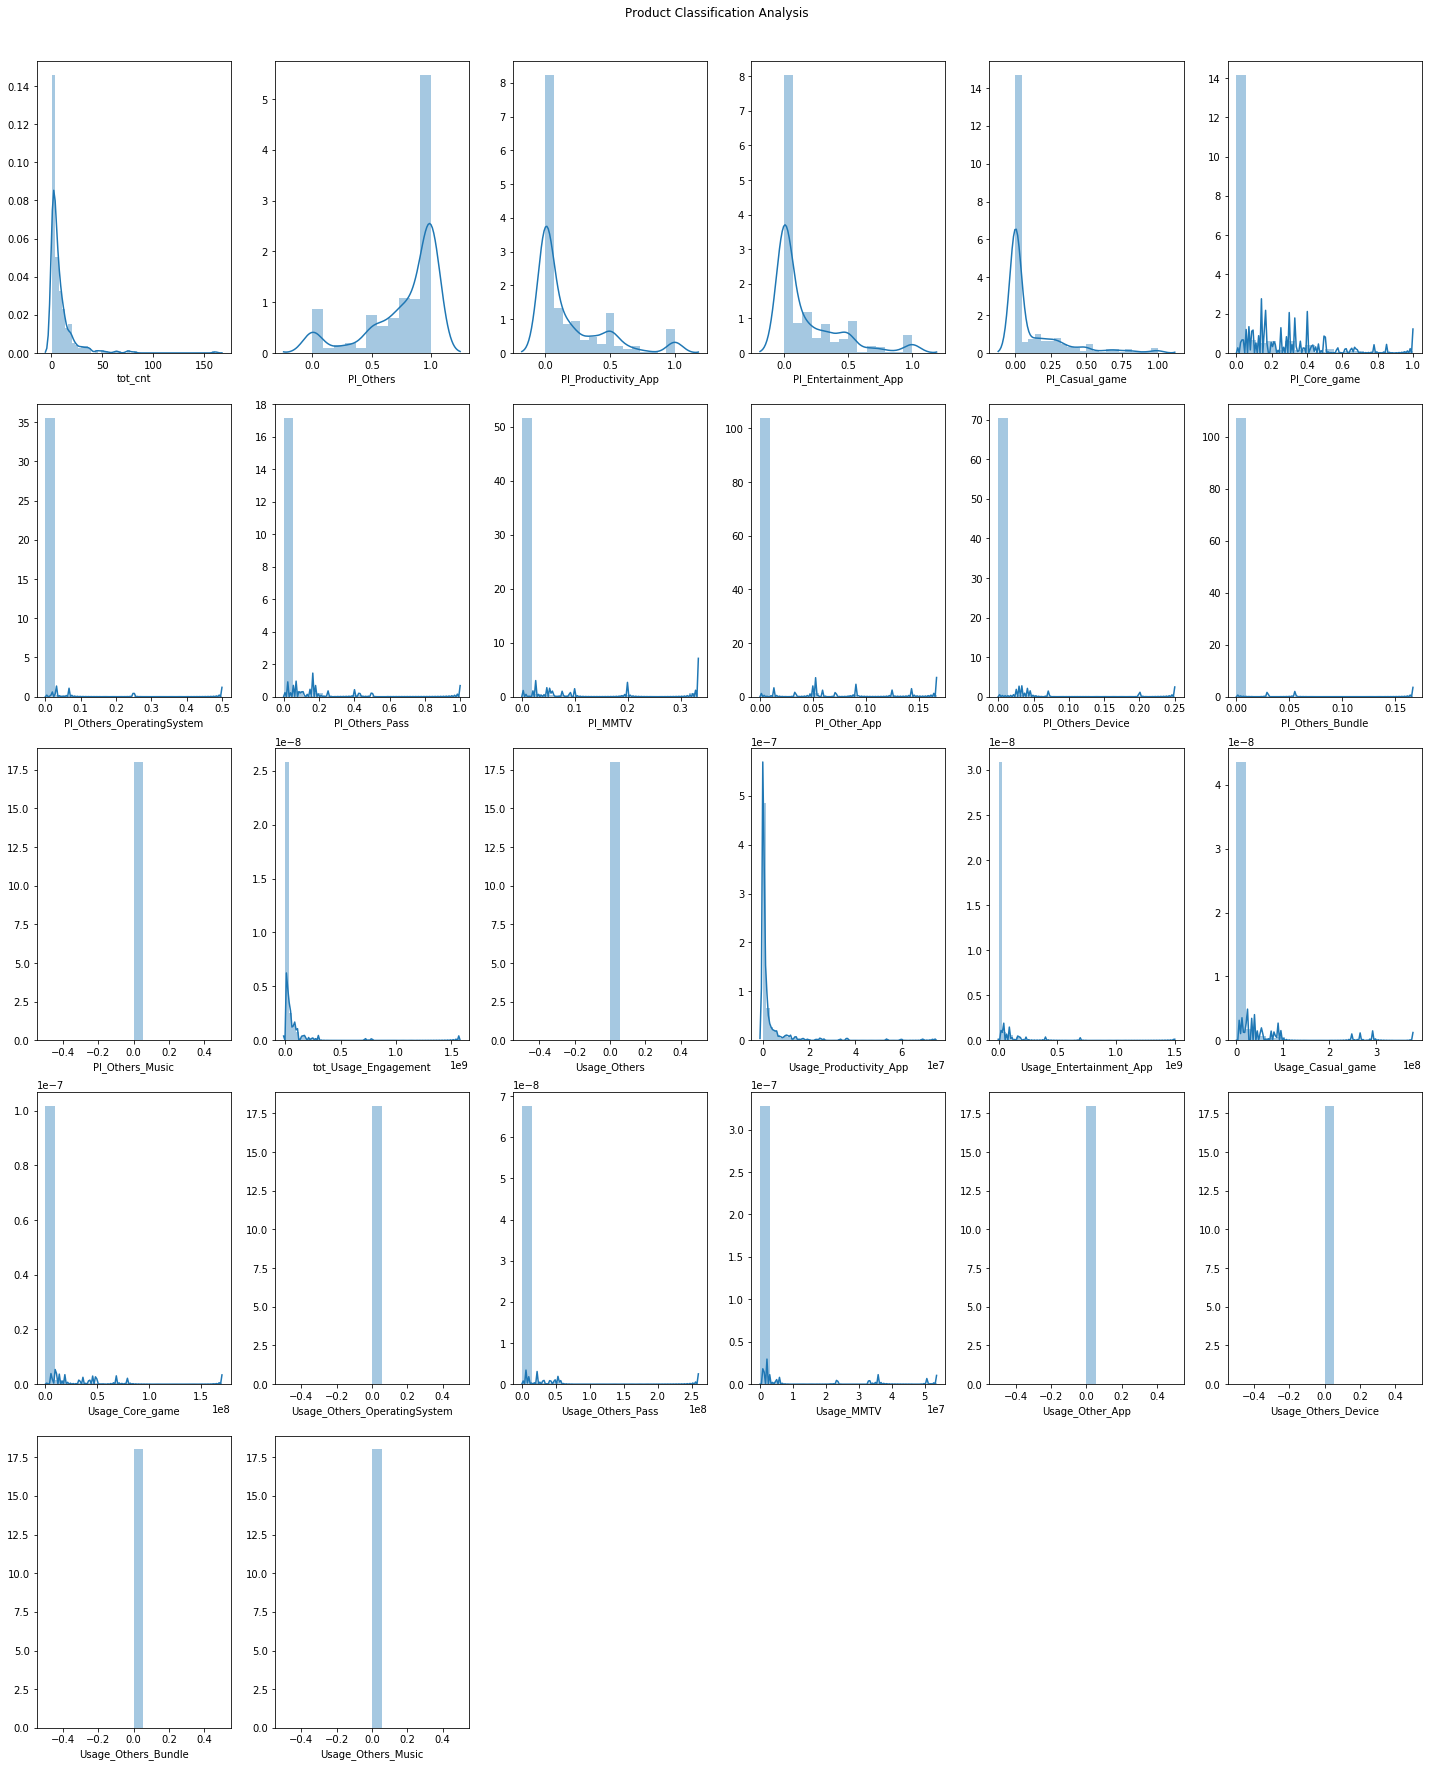

In [16]:
fig = plt.figure(figsize = (20, 25))
j = 0
for i in data_corr_numeric.columns:
    plt.subplot(5, 6, j+1)
    j += 1
    sns.distplot(data_corr_numeric[i])
    #plt.legend(loc='best')
fig.suptitle('Product Classification Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

- Data is skewed, mostly right tailed  except for PI_Others

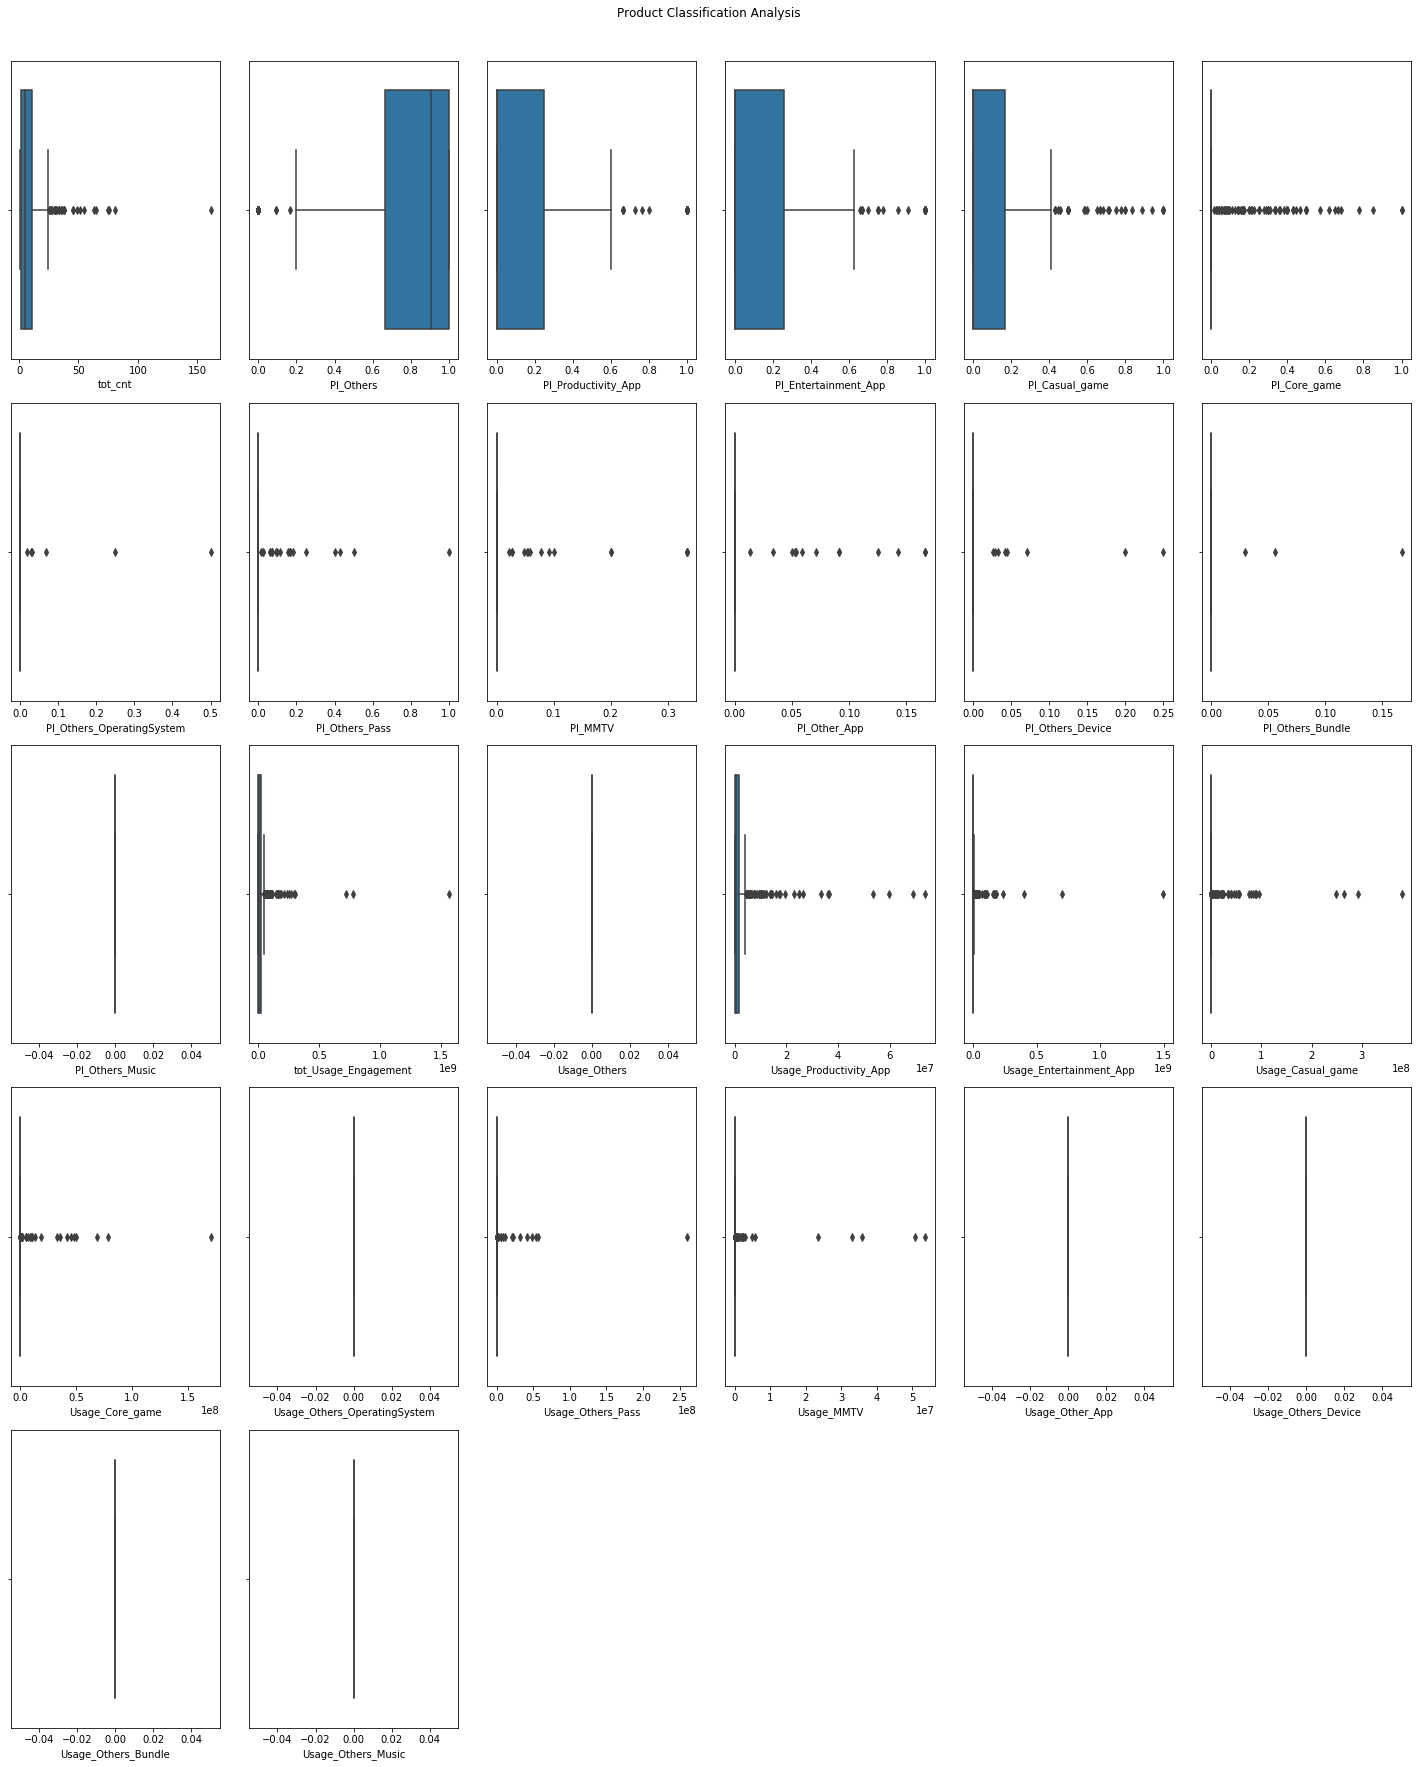

In [17]:
fig = plt.figure(figsize = (20, 25))
j = 0
for i in data_corr_numeric.columns:
    plt.subplot(5, 6, j+1)
    j += 1
    sns.boxplot(data_corr_numeric[i])
    #plt.legend(loc='best')
fig.suptitle('Product Classification Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

Lots of data outside IQR. Few columns are non-significant.

### 2.3 Bi-variate analysis

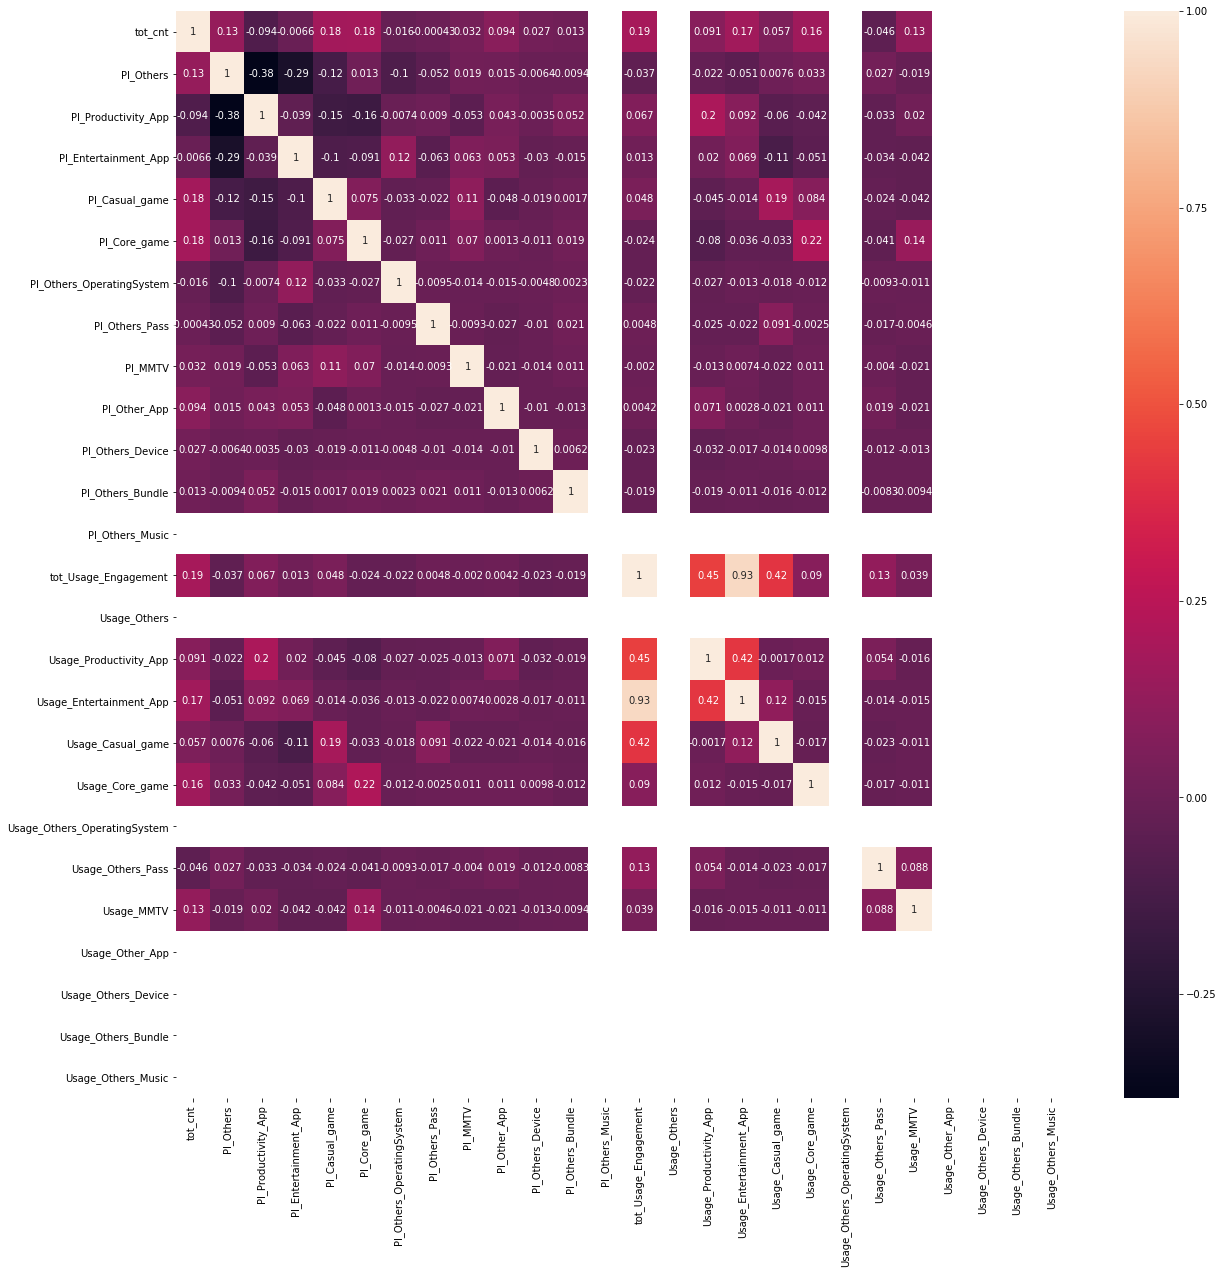

In [18]:
fig, ax = plt.subplots(figsize=(20,20))        
sns.heatmap(data_corr_numeric.corr(), annot=True, ax=ax)

- Not much correlation among variates.

C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; aut

C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; aut

C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; aut

C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; aut

C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; aut

C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:109: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  ax.set_ylim(boundaries_list[i])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:109: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  ax.set_ylim(boundaries_list[i])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:109: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  ax.set_ylim(boundaries_list[i])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:109: UserWarning: Attempting to set identical bottom==top results
in singular transformations; aut

C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; aut

C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:109: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  ax.set_ylim(boundaries_list[i])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:109: UserWarning: Attempting to set identical bottom==top results
in singular transformations; aut

C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:109: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  ax.set_ylim(boundaries_list[i])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:109: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  ax.set_ylim(boundaries_list[i])
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; aut

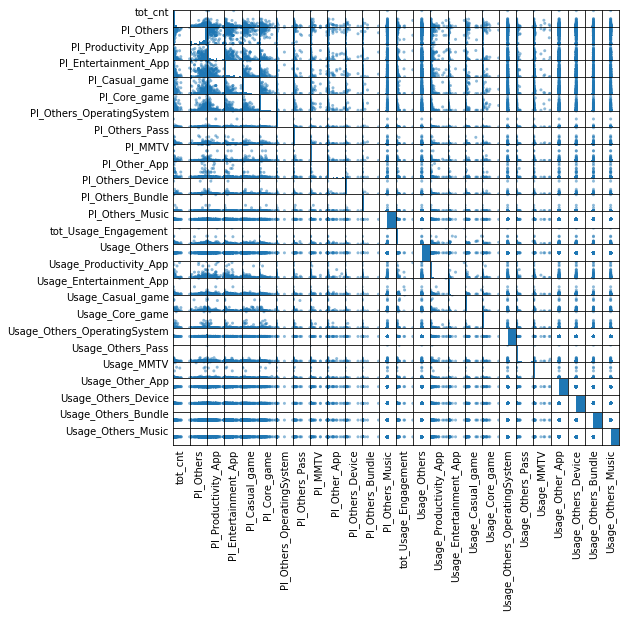

In [19]:
#numeric_data = df.select(numeric_features).toPandas()
axs = pd.plotting.scatter_matrix(data_corr_numeric, figsize=(8, 8));
n = len(data_corr_numeric.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

- As seen in heatmap, scatterplot supports no correlation among features.

### 3. Feature Engineering

### 3.1. Data Cleaning - Drop minuscule features 

In [20]:
# below features had 0 values so lets drop them
drop_cols = ['Usage_Others', 'Usage_Others_OperatingSystem', 'Usage_Other_App', 'Usage_Others_Device', 'Usage_Others_Bundle',\
             'Usage_Others_Music','PI_Others_Music']
data_corr = data_corr.select([c for c in data_corr.columns if c not in drop_cols])
data_corr.columns

['tot_cnt',
 'PI_Others',
 'PI_Productivity_App',
 'PI_Entertainment_App',
 'PI_Casual_game',
 'PI_Core_game',
 'PI_Others_OperatingSystem',
 'PI_Others_Pass',
 'PI_MMTV',
 'PI_Other_App',
 'PI_Others_Device',
 'PI_Others_Bundle',
 'tot_Usage_Engagement',
 'Usage_Productivity_App',
 'Usage_Entertainment_App',
 'Usage_Casual_game',
 'Usage_Core_game',
 'Usage_Others_Pass',
 'Usage_MMTV']

### 3.2 Log transformation  - As data is right skewed so apply log transformation to data point outside of Q1+Q3 range

Detect Outliers and address. Ideally feature-wise cut-off should be suggestd. 
Excpet for PI_others, most features are right skewed. Here generically log transformation is applied. 
- Next Step: apply exponential transformation for PI_others.
- Next Step: Boxcox transformation

In [21]:
d= {}
for col in data_corr.columns:
    d[col] = data_corr.approxQuantile(col,[0.25,0.75],0)
    print(col+" done")


tot_cnt done
PI_Others done
PI_Productivity_App done
PI_Entertainment_App done
PI_Casual_game done
PI_Core_game done
PI_Others_OperatingSystem done
PI_Others_Pass done
PI_MMTV done
PI_Other_App done
PI_Others_Device done
PI_Others_Bundle done
tot_Usage_Engagement done
Usage_Productivity_App done
Usage_Entertainment_App done
Usage_Casual_game done
Usage_Core_game done
Usage_Others_Pass done
Usage_MMTV done


In [22]:
d

{'tot_cnt': [2.0, 11.0],
 'PI_Others': [0.666666667, 1.0],
 'PI_Productivity_App': [0.0, 0.25],
 'PI_Entertainment_App': [0.0, 0.258064516],
 'PI_Casual_game': [0.0, 0.166666667],
 'PI_Core_game': [0.0, 0.0],
 'PI_Others_OperatingSystem': [0.0, 0.0],
 'PI_Others_Pass': [0.0, 0.0],
 'PI_MMTV': [0.0, 0.0],
 'PI_Other_App': [0.0, 0.0],
 'PI_Others_Device': [0.0, 0.0],
 'PI_Others_Bundle': [0.0, 0.0],
 'tot_Usage_Engagement': [512348.0, 19389657.0],
 'Usage_Productivity_App': [26859.0, 1723815.0],
 'Usage_Entertainment_App': [9423.0, 3497328.0],
 'Usage_Casual_game': [0.0, 0.0],
 'Usage_Core_game': [0.0, 0.0],
 'Usage_Others_Pass': [0.0, 0.0],
 'Usage_MMTV': [0.0, 0.0]}

Below log transformation is applied as data is skewed. Also there are > 10% outliers so dropping data results in 
extensive data loss

In [23]:
for col in data_corr.columns:
    data_corr = data_corr.withColumn(col +"_New", f.lit(-1))
    col_new =col +"_New"
    data_corr = data_corr\
    .withColumn(col_new,f.log(f.when(data_corr[col] < d[col][0],d[col][0])\
        .when(data_corr[col] > d[col][1], d[col][1])\
         .otherwise(data_corr[col])+1))

In [24]:
cols_new = [c for c in data_corr.columns if c.endswith('_New')]
data_corr_numeric = data_corr.select(cols_new).toPandas()

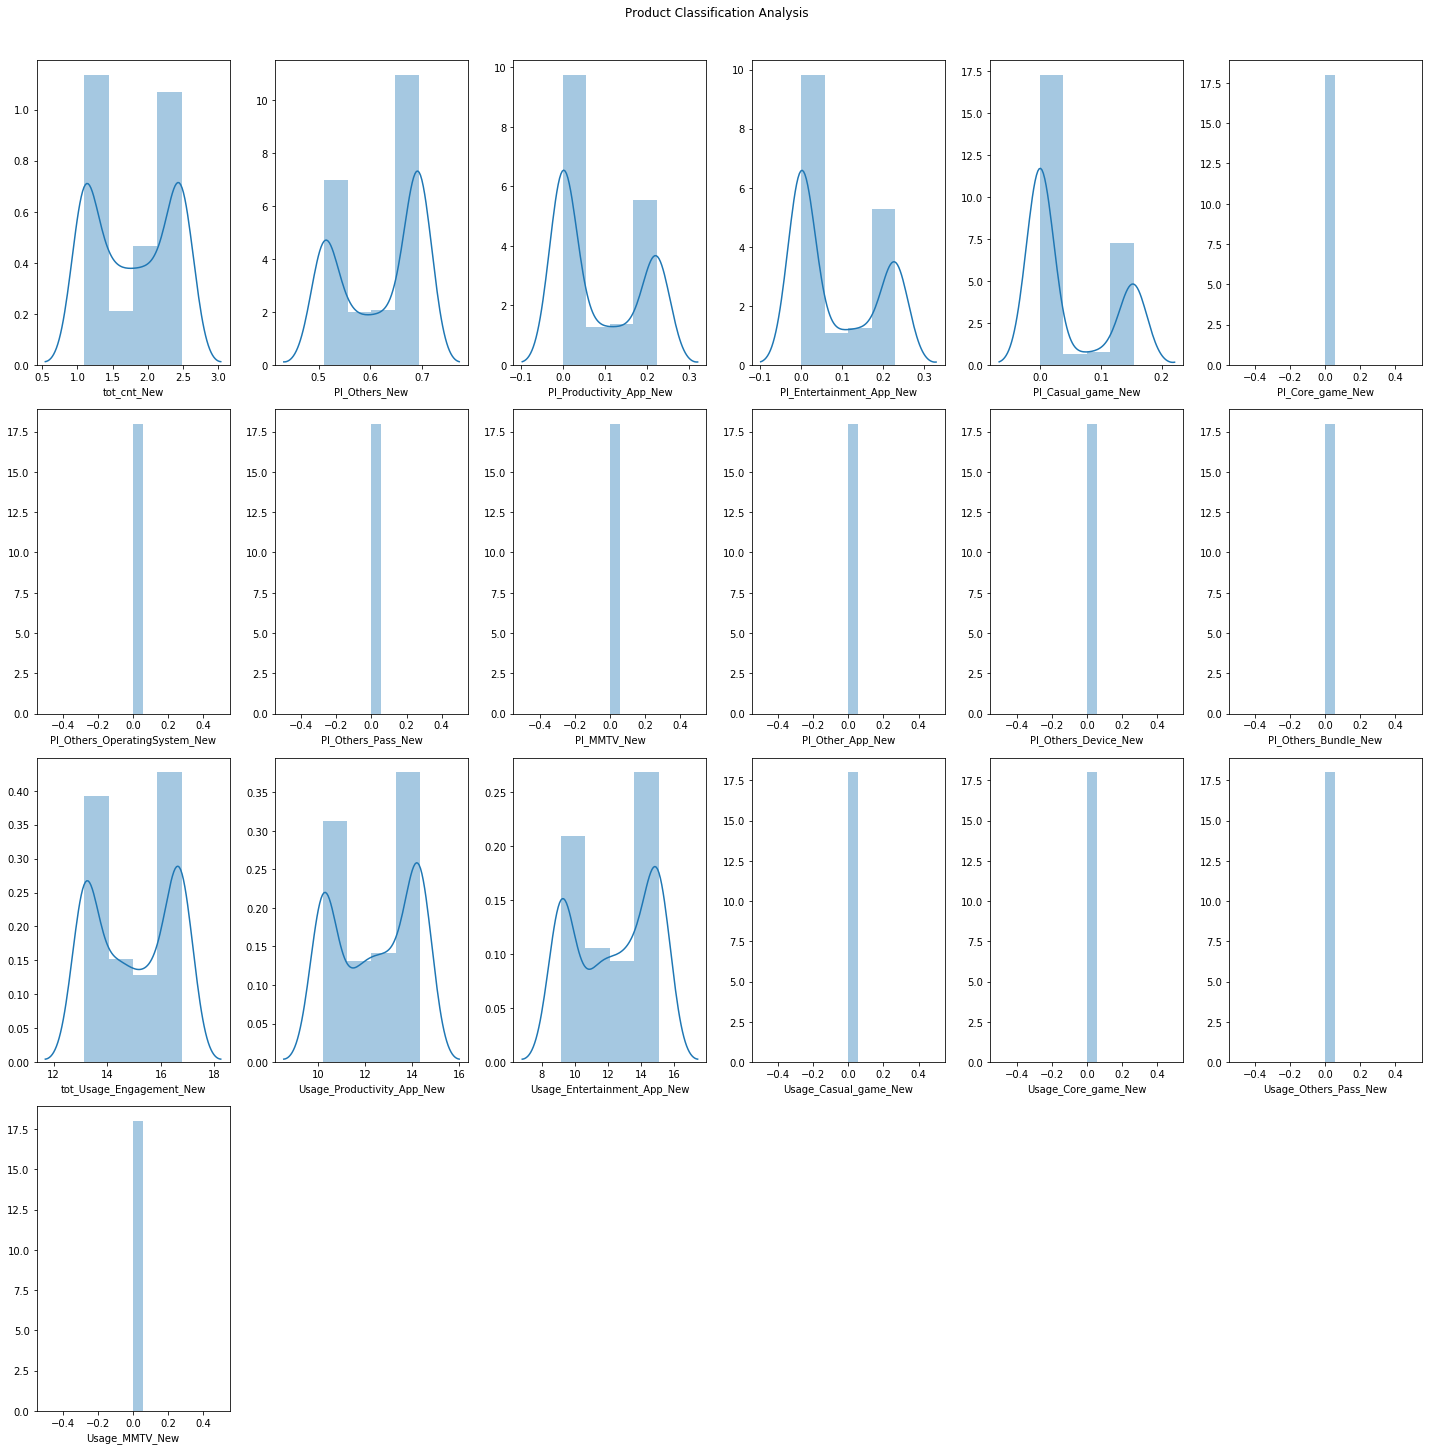

In [25]:
#plot transformed data

fig = plt.figure(figsize = (20, 25))
j = 0
for i in data_corr_numeric.columns:
    plt.subplot(5, 6, j+1)
    j += 1
    sns.distplot(data_corr_numeric[i])
    #plt.legend(loc='best')
fig.suptitle('Product Classification Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

Next Steps:- Data is still bi-modal, so still scope for further feature engg

Next Steps: Above graphs show that features are moslty 0, ot no correlation so model can be tried by removing them.

## 3.3 Vectorize

In [26]:
data_final = data_corr.select(cols_new)
cols=data_final.columns

In [27]:
# Let us import the vector assembler
assembler = VectorAssembler(inputCols=cols,outputCol="features")
# Now let us use the transform method to transform our dataset
raw_data=assembler.transform(data_final)
raw_data.select("features").show(truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                                                                              |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|(19,[0,1,12,13,14],[1.3862943611198906,0.6931471805599453,13.146761312435192,10.198393470077228,9.151014905891367])                                                                   |
|(19,[0,1,12,13,14],[1.0986122886681098,0.6931471805599453,16.780250389105575,14.360050995971596,9.208839245849916])                                                                   |
|(19,[0,1,2,12,13,14],[1.0986122886681098,0.5108256239659906,0.223143551314

## 3.4 Standardrize

In [28]:
standardscaler=StandardScaler().setInputCol("features").setOutputCol("Scaled_features")
raw_data=standardscaler.fit(raw_data).transform(raw_data)
raw_data.select("features","Scaled_features").show(5)

+--------------------+--------------------+
|            features|     Scaled_features|
+--------------------+--------------------+
|(19,[0,1,12,13,14...|(19,[0,1,12,13,14...|
|(19,[0,1,12,13,14...|(19,[0,1,12,13,14...|
|(19,[0,1,2,12,13,...|(19,[0,1,2,12,13,...|
|(19,[0,1,2,3,4,12...|(19,[0,1,2,3,4,12...|
|(19,[0,1,2,12,13,...|(19,[0,1,2,12,13,...|
+--------------------+--------------------+
only showing top 5 rows



## 3.5 train-test split

In [29]:
data2.columns

['AnonPuid',
 'tot_cnt',
 'PI_Others',
 'PI_Productivity_App',
 'PI_Entertainment_App',
 'PI_Casual_game',
 'PI_Core_game',
 'PI_Others_OperatingSystem',
 'PI_Others_Pass',
 'PI_MMTV',
 'PI_Other_App',
 'PI_Others_Device',
 'PI_Others_Bundle',
 'PI_Others_Music',
 'tot_Usage_Engagement',
 'Usage_Others',
 'Usage_Productivity_App',
 'Usage_Entertainment_App',
 'Usage_Casual_game',
 'Usage_Core_game',
 'Usage_Others_OperatingSystem',
 'Usage_Others_Pass',
 'Usage_MMTV',
 'Usage_Other_App',
 'Usage_Others_Device',
 'Usage_Others_Bundle',
 'Usage_Others_Music',
 'label_New']

In [30]:
## merge back "Anon Id" & "label_New"

In [31]:
df2=data2.select(["AnonPuid", "label_New"])
df2 = df2.withColumn("id", f.monotonically_increasing_id())
df2.columns

['AnonPuid', 'label_New', 'id']

In [32]:
raw_data = raw_data.withColumn("id", f.monotonically_increasing_id())

In [33]:
raw_data=raw_data.join(df2,on="id").drop("id")

In [34]:
## finally train test split

In [35]:
train, test = raw_data.randomSplit([0.8, 0.2], seed=12345)

In [36]:
train.columns

['tot_cnt_New',
 'PI_Others_New',
 'PI_Productivity_App_New',
 'PI_Entertainment_App_New',
 'PI_Casual_game_New',
 'PI_Core_game_New',
 'PI_Others_OperatingSystem_New',
 'PI_Others_Pass_New',
 'PI_MMTV_New',
 'PI_Other_App_New',
 'PI_Others_Device_New',
 'PI_Others_Bundle_New',
 'tot_Usage_Engagement_New',
 'Usage_Productivity_App_New',
 'Usage_Entertainment_App_New',
 'Usage_Casual_game_New',
 'Usage_Core_game_New',
 'Usage_Others_Pass_New',
 'Usage_MMTV_New',
 'features',
 'Scaled_features',
 'AnonPuid',
 'label_New']

In [37]:
# check class distribution
dataset_size=float(train.select("label_New").count())
numPositives=train.select("label_New").where('label_New == 0').count()
per_ones=(float(numPositives)/float(dataset_size))*100
numNegatives=float(dataset_size-numPositives)
print('The number of 0s are {}'.format(numPositives))
print('Percentage of 0s are {}'.format(per_ones))

The number of 0s are 215
Percentage of 0s are 77.89855072463769


- 77.9% data is 0 class so highly imbalance. Need to balance the data set and put heavier weights on minority class

## 3.6 Handling imbalance

In [38]:
BalancingRatio= numPositives/dataset_size
print('BalancingRatio = {}'.format(BalancingRatio))

BalancingRatio = 0.7789855072463768


In [39]:
train=train.withColumn("classWeights", f.when(train.label_New == 0,1-BalancingRatio).otherwise(BalancingRatio))
train.select("label_New","classWeights").show(5)

+---------+-------------------+
|label_New|       classWeights|
+---------+-------------------+
|        0|0.22101449275362317|
|        0|0.22101449275362317|
|        0|0.22101449275362317|
|        1| 0.7789855072463768|
|        0|0.22101449275362317|
+---------+-------------------+
only showing top 5 rows



Next steps - Explore SMOTE from pyspark lib
https://github.com/Angkirat/Smote-for-Spark/blob/master/PythonCode.py

## 3.7 see histogram distribution

In [40]:
# feat=['tot_cnt', 'PI_Others', 'PI_Productivity_App', 'PI_Entertainment_App', 'PI_Casual_game', \
#              'PI_Others_OperatingSystem', 'PI_Others_Pass', 'PI_MMTV', 'PI_Other_App', 'PI_Others_Device', 'PI_Others_Bundle', \
#              'PI_Others_Music', 'tot_Usage_Engagement', 'Usage_Others', 'Usage_Productivity_App', 'Usage_Entertainment_App', \
#              'Usage_Core_game', 'Usage_Others_OperatingSystem', 'Usage_Others_Pass', 'Usage_Other_App', 'Usage_Others_Device', \
#              'Usage_Others_Bundle', 'Usage_Others_Music', 'PI_Core_game_impute', 'Usage_Casual_game_impute', 'Usage_MMTV_impute']

feat=train.columns
feat.remove('AnonPuid')
feat.remove('features')
feat.remove('Scaled_features')
feat.remove('classWeights')
print (feat)

['tot_cnt_New', 'PI_Others_New', 'PI_Productivity_App_New', 'PI_Entertainment_App_New', 'PI_Casual_game_New', 'PI_Core_game_New', 'PI_Others_OperatingSystem_New', 'PI_Others_Pass_New', 'PI_MMTV_New', 'PI_Other_App_New', 'PI_Others_Device_New', 'PI_Others_Bundle_New', 'tot_Usage_Engagement_New', 'Usage_Productivity_App_New', 'Usage_Entertainment_App_New', 'Usage_Casual_game_New', 'Usage_Core_game_New', 'Usage_Others_Pass_New', 'Usage_MMTV_New', 'label_New']


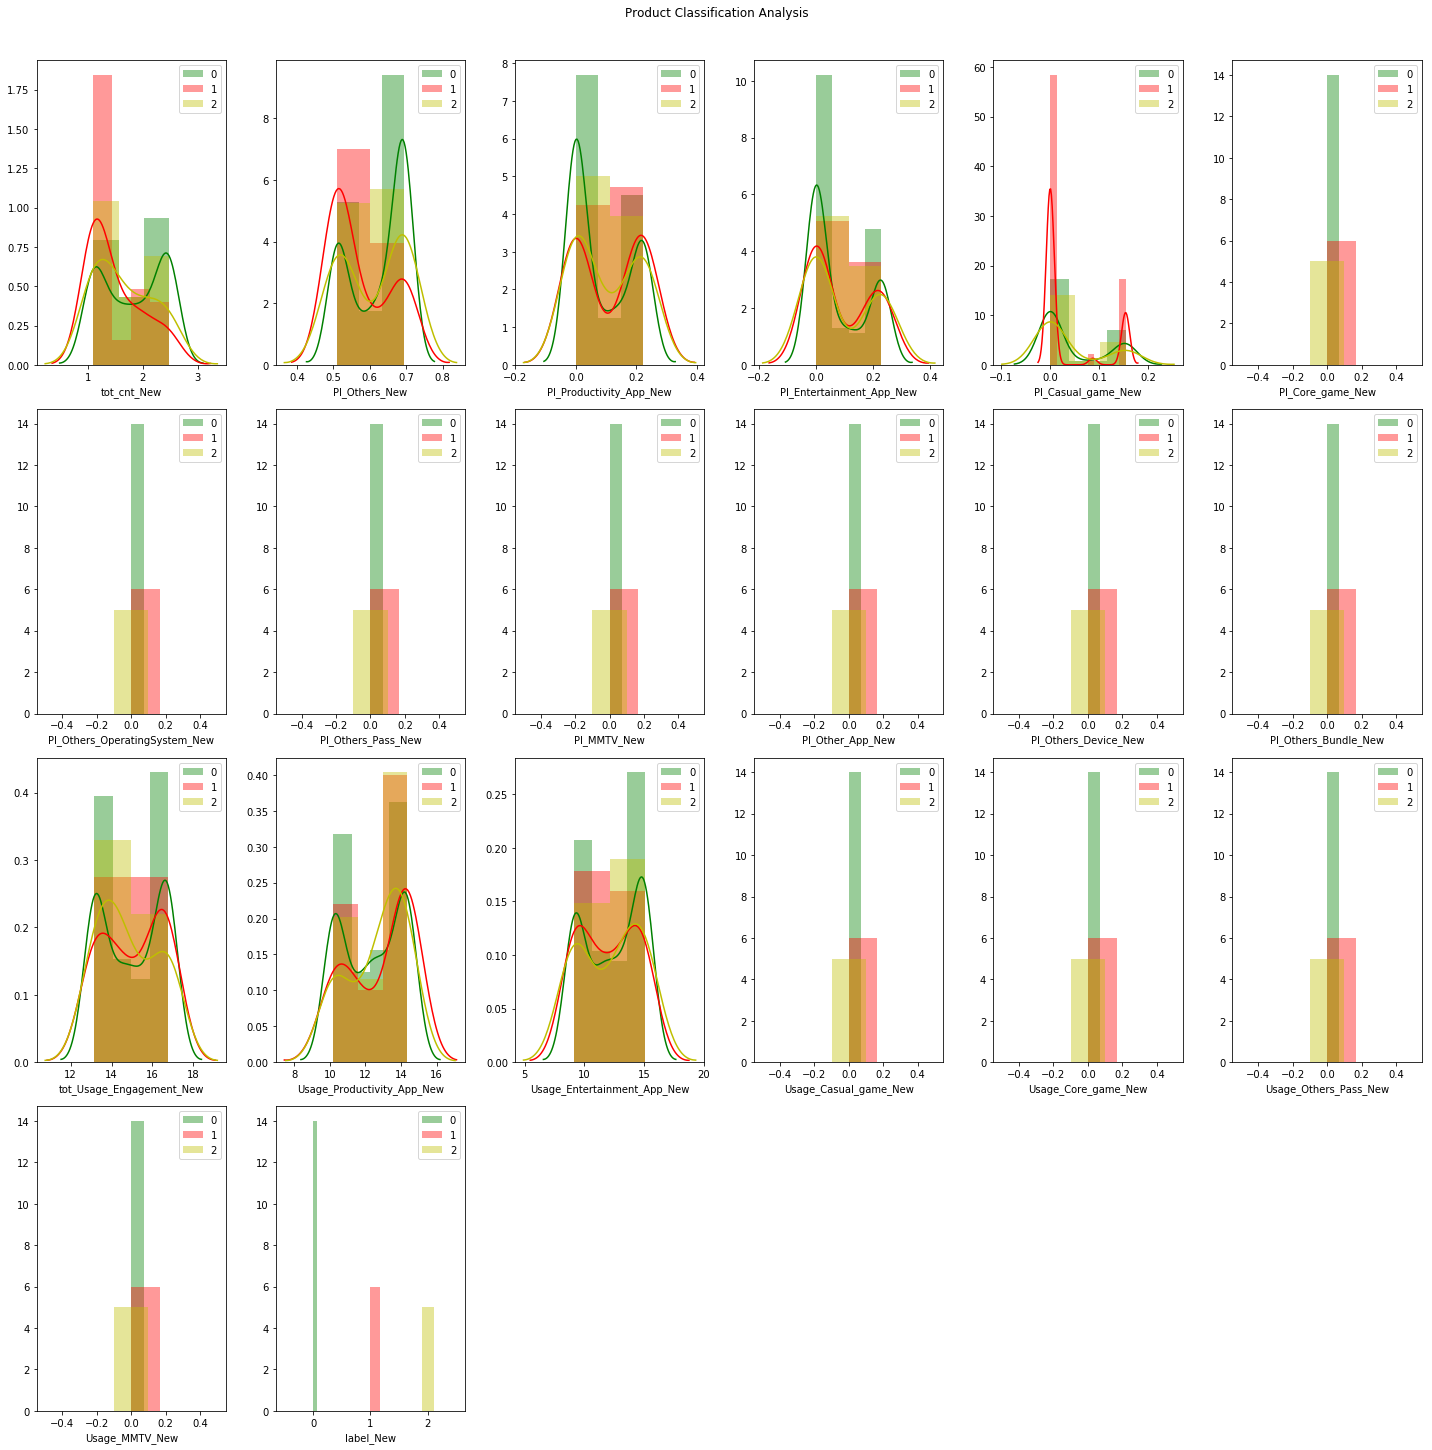

In [41]:
# plot data distribution by class

data_final_numeric = train.select(feat).toPandas()

fig = plt.figure(figsize = (20, 25))
j = 0
for i in data_final_numeric.columns:
    plt.subplot(5, 6, j+1)
    j += 1
    sns.distplot(data_final_numeric[i][data_final_numeric['label_New']==0], color='g', label = '0')
    sns.distplot(data_final_numeric[i][data_final_numeric['label_New']==1], color='r', label = '1')
    sns.distplot(data_final_numeric[i][data_final_numeric['label_New']==2], color='y', label = '2')
    plt.legend(loc='best')
fig.suptitle('Product Classification Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

## 3.8 Feature selection - correlation and chi-squared test

In [42]:
len(data_final_numeric.columns)

20

In [43]:
# select features where correlation < 0.9
corr = data_final_numeric.corr() 

columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9 or corr.iloc[i,j] <= -0.9:
            if columns[j]:
                columns[j] = False


selected_columns = data_final_numeric.columns[columns]
selected_columns

Index(['tot_cnt_New', 'PI_Others_New', 'PI_Productivity_App_New',
       'PI_Entertainment_App_New', 'PI_Casual_game_New', 'PI_Core_game_New',
       'PI_Others_OperatingSystem_New', 'PI_Others_Pass_New', 'PI_MMTV_New',
       'PI_Other_App_New', 'PI_Others_Device_New', 'PI_Others_Bundle_New',
       'tot_Usage_Engagement_New', 'Usage_Productivity_App_New',
       'Usage_Entertainment_App_New', 'Usage_Casual_game_New',
       'Usage_Core_game_New', 'Usage_Others_Pass_New', 'Usage_MMTV_New',
       'label_New'],
      dtype='object')

In [44]:
len(selected_columns)

20

In [45]:
## all features are selected

## Now try Feature selection using chisquareSelector

In [46]:
## select values based on p-value, null-hypothesis says this combination of features does not affects the independent variable.
## if p-value < threshold then it affects the prediction and hence kept in feature set (i.e. reject the null-hypothesis)

In [47]:
train.select("Scaled_features").show(5, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------+
|Scaled_features                                                                                                                                          |
+---------------------------------------------------------------------------------------------------------------------------------------------------------+
|(19,[0,1,12,13,14],[2.8515086732439805,8.738699573753637,8.879542909355262,7.537930099421633,4.974748301884964])                                         |
|(19,[0,1,2,3,12,13,14],[4.402613365405145,8.36233495478917,0.5824789017069343,1.1006217980221686,11.333662323271362,8.542347925757213,6.356300300440481])|
|(19,[0,1,2,3,12,13,14],[3.447650651520185,8.738699573753637,1.570888928302056,2.271730199793659,10.071093420563855,7.835464338962191,6.202749325079497]) |
|(19,[0,1,2,3,12,13,14],[2.8515086732439805,6.440120926132777,2.

In [48]:
css = ChiSqSelector(featuresCol='Scaled_features',outputCol='Aspect',labelCol='label_New',fpr=0.05)
train=css.fit(train).transform(train)
test=css.fit(test).transform(test)
test.select("Aspect").show(5,truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Aspect                                                                                                                                                                         |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|(19,[0,1,2,3,4,12,13,14],[4.402613365405145,7.537097588109729,0.7154239798878274,0.8610121043730214,1.9924546862278956,11.069201770354418,7.791080169067736,6.304221023177921])|
|(19,[0,1,2,4,12,13,14],[3.8929149679737094,8.738699573753637,2.273968132509036,1.728090565353641,8.886765214318283,6.066707237293883,5.5251171605819165])                      |
|(19,[0,1,2,3,4,12,13,14],[4.402613365405145,7.193017947978569,0.7552051861340329,2.271730199793659,2.26166981

## 4. Model Building

In [49]:
from pyspark.ml.classification import LogisticRegression
# lr = LogisticRegression().setWeightCol("classWeights").setLabelCol("Outcome").setFeaturesCol("Aspect")
lr = LogisticRegression(labelCol="label_New", featuresCol="Aspect",weightCol="classWeights",maxIter=10,family="multinomial")
model=lr.fit(train)
predict_train=model.transform(train)
predict_test=model.transform(test)
predict_test.select("label_New","prediction").show(10)

+---------+----------+
|label_New|prediction|
+---------+----------+
|        0|       0.0|
|        0|       0.0|
|        1|       0.0|
|        1|       1.0|
|        0|       0.0|
|        0|       0.0|
|        0|       0.0|
|        0|       0.0|
|        0|       0.0|
|        0|       0.0|
+---------+----------+
only showing top 10 rows



## 5 Model evaluation

In [50]:
ss= model.summary

In [51]:
print ("Accuracy is {}".format(ss.accuracy))

Accuracy is 0.717391304347826


In [52]:
# The BinaryClassificationEvaluator uses areaUnderROC as the default metric. As of now we will continue with the same
evaluator=BinaryClassificationEvaluator(rawPredictionCol="rawPrediction",labelCol="label_New")

In [53]:
predict_test.select("label_New","rawPrediction","prediction","probability").toPandas().head(5)

,label_New,rawPrediction,prediction,probability
0,0,"[0.8837158945856827, -0.44642140114833406, -0....",0.0,"[0.6530371372133574, 0.17268976238189698, 0.17..."
1,0,"[1.2587105036673814, -1.1963751566705894, -0.0...",0.0,"[0.7392557101449271, 0.06346942047629743, 0.19..."
2,1,"[0.7398757525660233, -0.4625463450982416, -0.2...",0.0,"[0.6016594750764546, 0.18077795886275824, 0.21..."
3,1,"[0.012610621629715102, 0.5285062018773766, -0....",1.0,"[0.30769786372815255, 0.5154363996699644, 0.17..."
4,0,"[0.8950171168742651, -0.6062964002546452, -0.2...",0.0,"[0.6540352434646283, 0.14574342634742754, 0.20..."


In [54]:
print("The area under ROC for train set is {}".format(evaluator.evaluate(predict_train)))
print("The area under ROC for test set is {}".format(evaluator.evaluate(predict_test)))

The area under ROC for train set is 0.6792603888677086
The area under ROC for test set is 0.7872596153846154


In [55]:
print(lr.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto, current: multinomial)
featuresCol: features column name. (default: features, current: Aspect)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: label_New)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound const

In [56]:
predict_test.select('prediction').toPandas()['prediction'].value_counts()

0.0    68
1.0     9
Name: prediction, dtype: int64

In [57]:
from sklearn.metrics import *

print (confusion_matrix(predict_test.select('label_New').toPandas(), predict_test.select('prediction').toPandas()))
print (classification_report(predict_test.select('label_New').toPandas(), predict_test.select('prediction').toPandas()))


[[58  6  0]
 [ 7  2  0]
 [ 3  1  0]]
              precision    recall  f1-score   support

           0       0.85      0.91      0.88        64
           1       0.22      0.22      0.22         9
           2       0.00      0.00      0.00         4

   micro avg       0.78      0.78      0.78        77
   macro avg       0.36      0.38      0.37        77
weighted avg       0.73      0.78      0.76        77



C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\v-suljai\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [58]:

evaluator = MulticlassClassificationEvaluator(
    labelCol="label_New", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predict_test)
print("Test Error = %g " % (1.0 - accuracy))

evaluator = MulticlassClassificationEvaluator(
    labelCol="label_New", predictionCol="prediction", metricName="weightedPrecision")
precision = evaluator.evaluate(predict_test)
print("Test Precision = %g " % (precision))

evaluator = MulticlassClassificationEvaluator(
    labelCol="label_New", predictionCol="prediction", metricName="weightedRecall")
recall = evaluator.evaluate(predict_test)
print("Test Recall = %g " % (recall))

Test Error = 0.220779 
Test Precision = 0.734912 
Test Recall = 0.779221 


Next steps - Work on cross validation to optmize LR hyper-parameters tuning
1. Try one-rest menthod for classification
2. Try ensemble method
3. Try KNN 
4. other accuracy measure
5. More freatures esp. Demographic
6. Cold start, - i.e. new user, new product category

In [61]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'Aspect', labelCol = 'label_New', maxDepth = 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.select('label_New', 'rawPrediction', 'prediction', 'probability').show(10)

IllegalArgumentException: 'Feature 0 is marked as Nominal (categorical), but it does not have the number of values specified.'

In [59]:
model.coefficientMatrix

SparseMatrix(3, 19, [0, 8, 16, 24], [0, 1, 2, 3, 4, 12, 13, 14, ..., 0, 1, 2, 3, 4, 12, 13, 14], [0.3922, 0.127, -0.0676, -0.077, -0.0651, -0.0686, -0.1888, 0.0402, ..., -0.009, 0.1084, 0.0676, 0.0618, 0.0228, -0.1346, 0.045, 0.0285], 1)

In [60]:
beta = np.sort(model.coefficientMatrix)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

AxisError: axis -1 is out of bounds for array of dimension 0

In [ ]:
roc = ss.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [ ]:
# from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# paramGrid = ParamGridBuilder()\
#     .addGrid(lr.aggregationDepth,[2,5,10])\
#     .addGrid(lr.elasticNetParam,[0.0, 0.5, 1.0])\
#     .addGrid(lr.fitIntercept,[False, True])\
#     .addGrid(lr.maxIter,[10, 100, 1000])\
#     .addGrid(lr.regParam,[0.01, 0.5, 2.0]) \
#     .build()

In [ ]:
# # Create 5-fold CrossValidator
# cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# # Run cross validations
# cvModel = cv.fit(train)
# # this will likely take a fair amount of time because of the amount of models that we're creating and testing
# predict_train=cvModel.transform(train)
# predict_test=cvModel.transform(test)
# print("The area under ROC for train set after CV  is {}".format(evaluator.evaluate(predict_train)))
# print("The area under ROC for test set after CV  is {}".format(evaluator.evaluate(predict_test)))

In [ ]:
print (predict_test.toPandas().head(5))